In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,4

### ДЗ. 
Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [3]:
sales_of_company_x = pd.read_csv('monthly-sales-of-company-x-jan-6.csv')
airlines_passengers = pd.read_csv("international-airline-passengers.csv")
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")

In [13]:
def plot_TS(series, size=(12,4), title='Figure', label = 'original'):
    fig = plt.figure(figsize=size)
    plt.plot(series,label=label)
    
    plt.legend(loc='best')
    plt.title(title)
    plt.grid()

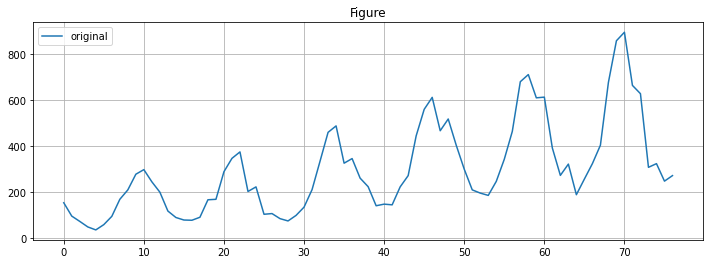

In [14]:
plot_TS(sales_of_company_x["Count"])

#### MA

In [40]:
def plot_MA(series,window = 3,label='MA_{window}', title='Comparing Moving Averages (MA)'):
    if label=='MA_{window}': label=f'MA_{window}'
    plot_TS(series, title=title)
    plt.plot(series.rolling(window).mean(),label=label)
    plt.legend()
    return None

In [506]:
def get_MA(series, window=3):
    return series.rolling(window).mean()

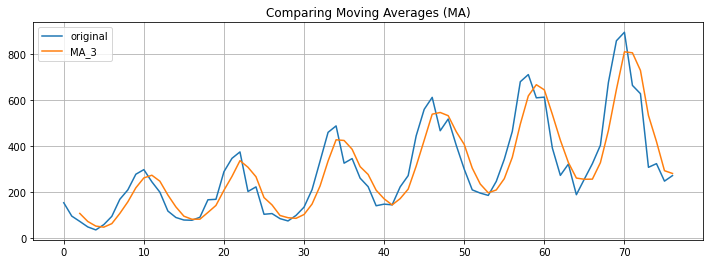

In [58]:
plot_MA(sales_of_company_x["Count"],window = 3 )

In [61]:
def MA_predict(series, window=3, n_steps = 5):
    array = np.array(series)[-window:]

    for i in range(n_steps):
        array = np.append(array,array[-window:].mean() )
        
    return array[-n_steps:]

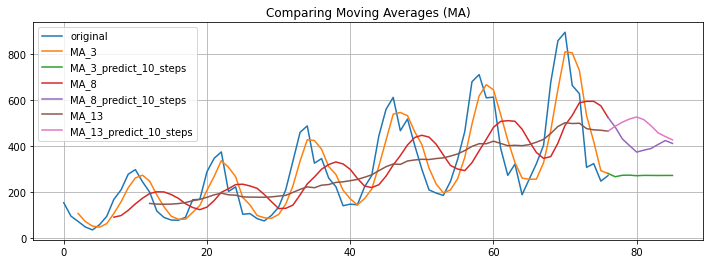

In [78]:
series = sales_of_company_x["Count"]
plot_TS(series, title='Comparing Moving Averages (MA)')
    
last_x = len(series)

for window in range(3,18,5):
    plt.plot(series.rolling(window).mean(),label=f'MA_{window}')

    plt.plot(range(last_x-1,last_x+9,1) , MA_predict(series, window=window, n_steps = 10) ,label=f'MA_{window}_predict_10_steps'  )

plt.legend()

#### weights_MA (WMA)

In [552]:
def get_MA_weights(series, weights = [.2,.3,.5] ):
    weights = np.array(weights)
    weights = weights/np.sum(weights)
    window = len(weights)
    array = []
    
    for i in range(window):
        array.append(np.nan)

    for i in range(len(series)- window-1 ):
        m = (np.array(series[i:window+i]) * weights).sum()
        array.append(m)
    #series.rolling(window).apply(lambda x: (x * weights).sum()

    return np.array(array)

In [560]:
def WMA_predict(series, weights = [.2,.3,.5] , n_steps = 5):
    weights = np.array(weights)
    weights = weights/np.sum(weights)
    window = len(weights)
    array = np.array(series)[-window:]

    for i in range(n_steps):
        m = np.sum( array[-window:] * weights )
        array = np.append(array,m )
        
    return array[-n_steps:]

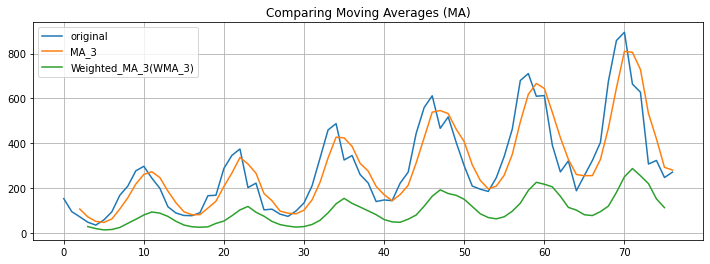

In [113]:
plot_MA(sales_of_company_x["Count"],window = 3 )
plt.plot(get_MA_weights(series,weights=[.1,.5,.7]), label='Weighted_MA_3(WMA_3)' )
plt.legend()

#### EMA

In [130]:
def get_exponential_MA(series, alpha = .5):
    result = [series[0]]

    for i in series:
        result.append(i*alpha + (1-alpha)*result[-1])

    return np.array(result)

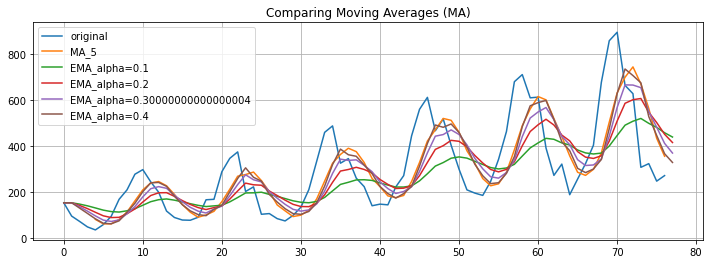

In [141]:
plot_MA(series,window=5)
for i in np.arange(0.1,.4,.1):
    plt.plot(get_exponential_MA(series,alpha=i), label=f'EMA_alpha={i}')
plt.legend()

In [162]:
def EMA_predict(series, alpha=.4,n_steps=5):
    series = np.array(series)
    y_pred = alpha * series[-1]+ (1-alpha) * get_exponential_MA(series,alpha=alpha)[-1]
    result = [series[-1],y_pred]

    for i in range(n_steps):
        result.append(alpha*result[-1] + (1-alpha)*result[-2]  )
    return np.array(result)[2:]    

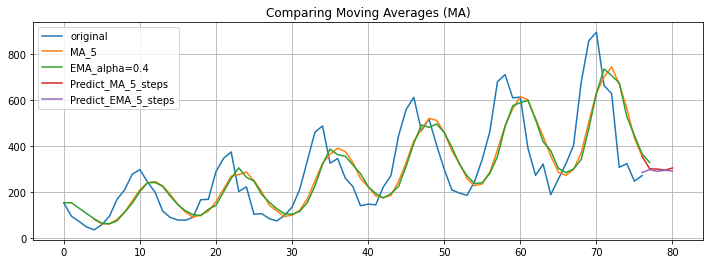

In [163]:
plot_MA(series,window=5)
plt.plot(get_exponential_MA(series,alpha=.4), label=f'EMA_alpha={.4}')

plt.plot(range(last_x-1,last_x+4), MA_predict(series,window=5,n_steps=5), label=f'Predict_MA_5_steps')
plt.plot(range(last_x-1,last_x+4),EMA_predict(series,alpha=.4,n_steps=5), label=f'Predict_EMA_5_steps')
plt.legend()

#### Double Exponential MA (DEMA)

In [310]:
def get_DEMA(series, alpha = .4, betta = .3):
    l = [series[0]]
    s = [0]
    y_dema = []
    
    for i in series:
        l.append( alpha * i + ( 1 - alpha )*( l[-1] + s[-1] )  )
        s.append( betta * ( l[-1] - l[-2]) + ( 1 - betta )*s[-1]  )
        y_dema.append( l[-1] + s[-1] )
    return np.array(y_dema), l,s

In [305]:
def DEMA_predict(series, n_steps=5, alpha = .4, betta = .3):
    
    l,s = get_DEMA(series, alpha = alpha, betta = betta)[1:]
    
    result = [np.array(series)[-1]]
       
    for i in range(1,n_steps+1):
        
        l.append( alpha * result[-1] + ( 1 - alpha )*( l[-1] + s[-1] )  )
        
        s.append( betta * ( l[-1] - l[-2]) + ( 1 - betta )*s[-1]  )
        
        result.append( l[-1] + i*s[-1] )
    
    return np.array(result)[1:]

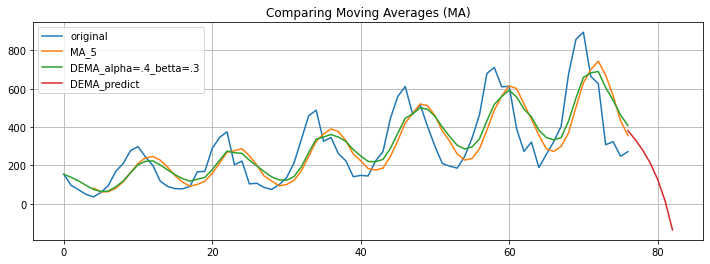

In [314]:
plot_MA(series,window=5)
plt.plot(get_DEMA(series,alpha=.25,betta=.1)[0], label='DEMA_alpha=.4_betta=.3')

plt.plot(range(TS_length-1,TS_length+6), DEMA_predict(series, n_steps=7,alpha=.2,betta=.2), label='DEMA_predict')
plt.legend()

#### TEMA

In [258]:
def TEMA_get_initial_p(series, season_length = 12):    

    TS_length = len(series)

    n_seasons = int( TS_length/season_length )
    season_average = []

    for i in range(n_seasons):
        season_average.append( np.sum(series[ 0+i*season_length : season_length + i*season_length ]) / season_length )

    p = dict()

    for i in range(n_seasons):

        for j in range(season_length):
            position = i*season_length + j

            p[j] = p.get(j,0) +  series[position] - season_average[i]

    for key,data in p.items():
        p[key] = data/n_seasons
        
    return p

In [195]:
def TEMA_get_initial_s(series, season_length = 12):
    trend = 0 
    for i in range( season_length ):
        trend += (series[i+ season_length] - series[i]) / season_length
    return trend/season_length

In [398]:
def get_TEMA(series, alpha = .2, betta = .3, gamma=.1):
    '''
         Holt - Winters method
    ''' 
    series = np.array(series)
    l = [series[0]]
    # проверка если входной массив очень маленький, то начальный тренд равен .3
    if len(series) < 24 :s = [TEMA_get_initial_s(series, season_length=int(len(series)/2) )] # s = [.3] 
    else: s = [TEMA_get_initial_s(series, season_length=12)]
        
    p = TEMA_get_initial_p(series, season_length=12)
    y_tema = []
    
    for i in range( len(series) ) :
        l.append( alpha * (series[i] - p[ i%season_length ] ) + ( 1 - alpha )*( l[-1] + s[-1] )  )
        s.append( betta * ( l[-1] - l[-2]) + ( 1 - betta )*s[-1]  )
        
        p[ i%season_length ] = gamma * (series[i] - l[-1] ) + ( 1 - gamma)* p[ i%season_length ] 
        y_tema.append( l[-1] + s[-1] + p[ i%season_length ])
        
    return np.array(y_tema) , l , s, p

In [270]:
def TEMA_predict(series,n_steps=5, alpha = .4, betta = .3, gamma=.1):
    l,s,p = get_TEMA(series, alpha = alpha, betta = betta, gamma=gamma)[1:]
    result = []
    start = TS_length % season_length
    
    for i in range(1,n_steps+1):
        result.append( l[-1] + i*s[-1] + p[(start+i)%season_length] )
    
    return np.array(result)

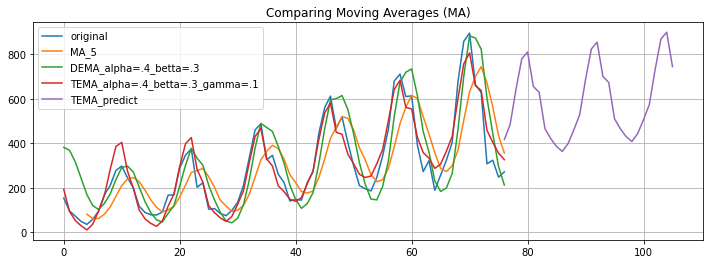

In [281]:
plot_MA(series,window=5)
plt.plot(get_DEMA(series, alpha=.4,betta=.3), label='DEMA_alpha=.4_betta=.3')
plt.plot(get_TEMA(series, alpha = .1, betta = .1, gamma=.2)[0], label='TEMA_alpha=.4_betta=.3_gamma=.1')

plt.plot(range(TS_length-1,TS_length+29), TEMA_predict(series, n_steps=30,alpha = .1, betta = .1, gamma=.2), label='TEMA_predict')
plt.legend()

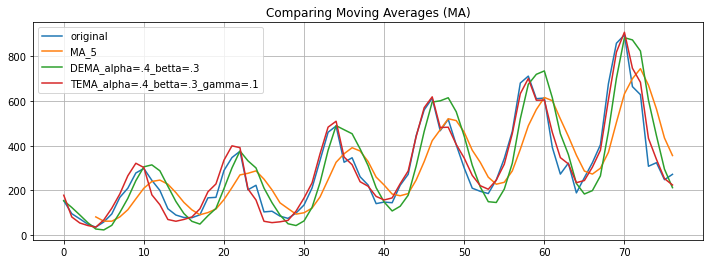

In [316]:
plot_MA(series,window=5)
plt.plot(get_DEMA(series, alpha=.4,betta=.3)[0], label='DEMA_alpha=.4_betta=.3')
plt.plot(get_TEMA(series, alpha = .4, betta = .3, gamma=.1)[0], label='TEMA_alpha=.4_betta=.3_gamma=.1')

plt.legend()

#### RMSE

In [318]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [403]:
test_size = .15
train_length = int( len(series) * (1- test_size) )
X_train, X_test = series[:train_length] , series[train_length :] 

In [409]:
def MSE(coefs):
    alpha, betta, gamma = coefs
    y_pred = TEMA_predict(X_train, n_steps=len(X_test), alpha=alpha, betta=betta, gamma=gamma)
    return mean_squared_error(X_test, y_pred)
    

In [404]:
MSE([.2,.3,.1])

22267.68472609196

In [410]:
opt = minimize(MSE, x0=[.2,.01,.01], method='L-BFGS-B', bounds=( (0,1),(0,1),(0,1) ) )

In [411]:
alpha_opt, betta_opt, gamma_opt = opt.x
print(opt)

      fun: 9122.425149958166
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.25687938e-02, -1.59273349e+03, -3.92377167e+03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 88
      nit: 12
     njev: 22
   status: 0
  success: True
        x: array([0.03334725, 1.        , 1.        ])


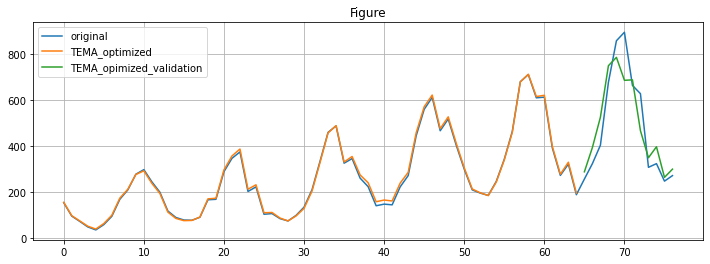

In [414]:
plot_TS(series)

plt.plot(get_TEMA(X_train, alpha = alpha_opt, betta = betta_opt, gamma=gamma_opt)[0], label='TEMA_optimized')

plt.plot(range(len(series) - len(X_test), len(series)) ,TEMA_predict(X_train,n_steps=len(X_test), alpha= alpha_opt, betta=betta_opt, gamma=gamma_opt ), label = 'TEMA_opimized_validation' )

plt.legend()

In [330]:
from sklearn.model_selection import TimeSeriesSplit

In [432]:
def MSE_cross_val(coefs):
    alpha, betta, gamma = coefs
    split = TimeSeriesSplit(n_splits=5)
    errors = []
    
    for train_split, test_split in split.split(X_train):
        #print(train_split, test_split)
        train_TS = np.array( X_train.iloc[train_split] )
        test_TS = np.array( X_train.iloc[test_split] )
        #print(train_TS, test_TS)
        y_pred = TEMA_predict(train_TS, n_steps=len(test_TS), alpha=alpha, betta=betta, gamma=gamma )
        mse = mean_squared_error(test_TS, y_pred)
        errors.append(mse)
    
    errors = np.array(errors)
    mean_error = np.mean( errors )
    print( f'---{mean_error}--- '  )
    return mean_error

In [ ]:
opt = minimize(MSE_cross_val, x0=[0,0,0], method='Nelder-Mead', bounds=( (0,1),(0,1),(0,1) )  ) # 'L-BFGS-B'

In [435]:
alpha_opt, betta_opt, gamma_opt = opt.x
print(opt)

 final_simplex: (array([[ 0.17642444,  0.1396286 , -0.45929433],
       [ 0.17640805,  0.13966819, -0.45927145],
       [ 0.17641954,  0.13964892, -0.45922519],
       [ 0.17644362,  0.13964518, -0.45929805]]), array([24134.44023973, 24134.44024897, 24134.4402611 , 24134.4403335 ]))
           fun: 24134.440239726413
       message: 'Optimization terminated successfully.'
          nfev: 225
           nit: 125
        status: 0
       success: True
             x: array([ 0.17642444,  0.1396286 , -0.45929433])


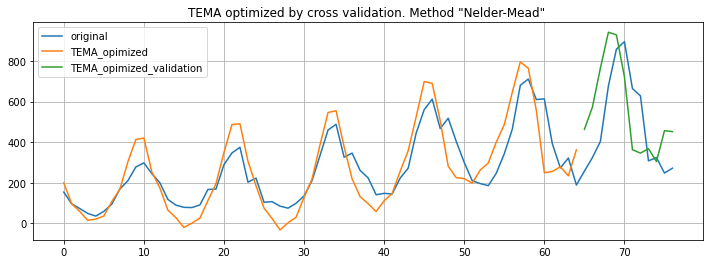

In [438]:
plot_TS(series, title='TEMA optimized by cross validation. Method "Nelder-Mead" ' )

plt.plot(range(0,len(X_train) ) ,get_TEMA(X_train, alpha= alpha_opt, betta=betta_opt, gamma=gamma_opt )[0], label = 'TEMA_opimized' )

plt.plot(range(len(series) - len(X_test), len(series)) ,TEMA_predict(X_train,n_steps=len(X_test), alpha= alpha_opt, betta=betta_opt, gamma=gamma_opt ), label = 'TEMA_opimized_validation' )
plt.legend()

#### Вывод по первой части:
- модели скользящей средней MR как правило показывают очень хорошие результаты на тестовой выборке но очень плохо могут в прогнозирование
- моделью TEMA можно хорошо построить ряд, даже не обязательно приводить его к стационарному виду. В памяти, для эконмии места, можно хранить только формулу


### ДЗ.часть 2. Взять стационарый и не стационарный ряд, разбить и проверить на валидайионной выборке и по MSE

In [ ]:
# НЕ стационарный
airlines_passengers = pd.read_csv("international-airline-passengers.csv")
# стационарный
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")

#### НЕ стационарный ряд

In [442]:
series = airlines_passengers.Count
TS_length = len(series)

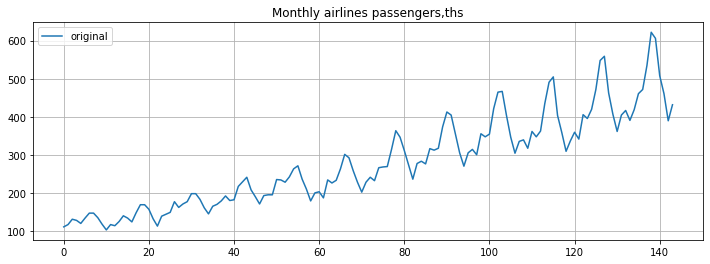

In [446]:
plot_TS(series, title='Monthly airlines passengers,ths')

У этого ряда есть тренд и сезонность, с периодом, примерно, 12 мес. Значит нужно использовать Triple Exponential MA (TEMA)
- разобъем ряд на треин тест 
- оптимизируем коэффициенты TEMA
- проверим на тест(валидационной выборке)

In [458]:
test_size = .1
train_length = int( len(series) * (1- test_size) )
X_train, X_test = series[:train_length] , series[train_length :] 

оптимизируем коэффициенты TEMA

In [459]:
opt = minimize(MSE, x0=[.2,.01,.01], method='L-BFGS-B', bounds=( (0,1),(0,1),(0,1) ) )

In [460]:
alpha_opt, betta_opt, gamma_opt = opt.x
print(opt)

      fun: 6638.353031299336
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.81898940e-04, -7.44210407e+01,  1.01467363e+04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 184
      nit: 24
     njev: 46
   status: 0
  success: True
        x: array([0.02032934, 1.        , 0.        ])


проверим на тест(валидационной выборке)

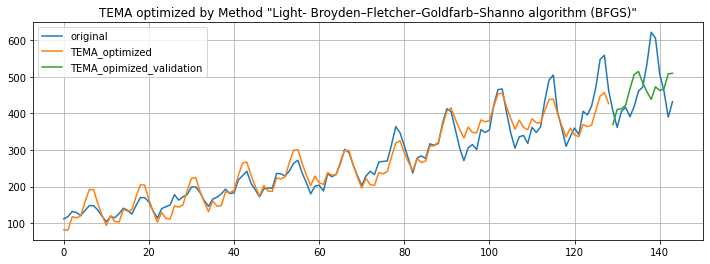

In [461]:
plot_TS(series, title='TEMA optimized by Method "Light- Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS)"')

plt.plot(get_TEMA(X_train, alpha = alpha_opt, betta = betta_opt, gamma=gamma_opt)[0], label='TEMA_optimized')

plt.plot(range(len(series) - len(X_test), len(series)) ,TEMA_predict(X_train,n_steps=len(X_test), alpha= alpha_opt, betta=betta_opt, gamma=gamma_opt ), label = 'TEMA_opimized_validation' )

plt.legend()

Ошибка MSE = 6638  
проверим на cross validation 'Nelder-Mead'

In [ ]:
opt = minimize(MSE_cross_val, x0=[0,0,0], method='Nelder-Mead', bounds=( (0,1),(0,1),(0,1) )  ) # 'L-BFGS-B'

In [464]:
alpha_opt, betta_opt, gamma_opt = opt.x
print(opt)

 final_simplex: (array([[ 0.18744088,  0.04092313, -0.03682389],
       [ 0.18748399,  0.04090593, -0.03682917],
       [ 0.18734273,  0.04092479, -0.03681757],
       [ 0.18751867,  0.04091759, -0.03679178]]), array([2083.54340671, 2083.5434096 , 2083.54341157, 2083.54341182]))
           fun: 2083.543406707812
       message: 'Optimization terminated successfully.'
          nfev: 157
           nit: 90
        status: 0
       success: True
             x: array([ 0.18744088,  0.04092313, -0.03682389])


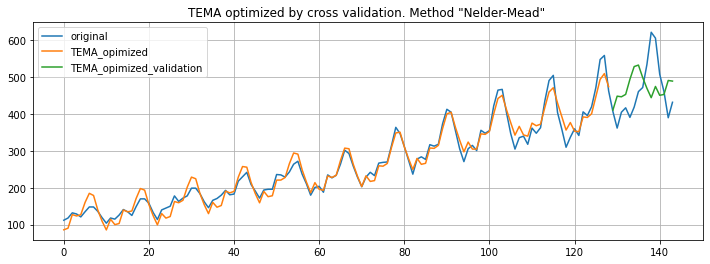

In [465]:
plot_TS(series, title='TEMA optimized by cross validation. Method "Nelder-Mead" ' )

plt.plot(range(0,len(X_train) ) ,get_TEMA(X_train, alpha= alpha_opt, betta=betta_opt, gamma=gamma_opt )[0], label = 'TEMA_opimized' )

plt.plot(range(len(series) - len(X_test), len(series)) ,TEMA_predict(X_train,n_steps=len(X_test), alpha= alpha_opt, betta=betta_opt, gamma=gamma_opt ), label = 'TEMA_opimized_validation' )
plt.legend()

#### Результаты первого ряда : 
    Метод 'Light- BFGS': ошибка MSE = 6638
    Метод 'Nelder-Mead': ошибка MSE = 2083
   
Лучший результат у 'Nelder-Mead'

In [ ]:
# НЕ стационарный
airlines_passengers = pd.read_csv("international-airline-passengers.csv")
# стационарный
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")

#### Стационарный ряд

In [467]:
series = female_births.Count
TS_length = len(series)

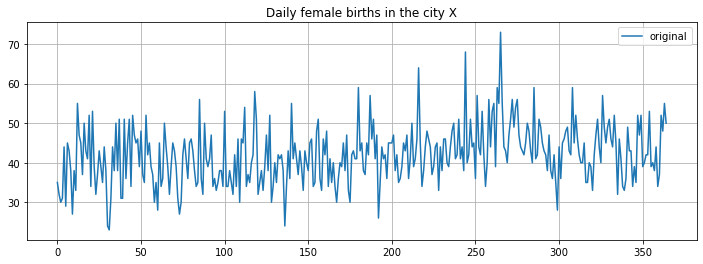

In [469]:
plot_TS(series, title='Daily female births in the city X')

У этого ряда нет ни тренда, ни сезонности. Значит применяем EMA
- разобъем ряд на треин тест 
- оптимизируем коэффициенты EMA
- проверим на тест(валидационной выборке)

In [471]:
test_size = .1
train_length = int( len(series) * (1- test_size) )
X_train, X_test = series[:train_length] , series[train_length :] 

Проверим MA

In [510]:
for window in range(3,35,3):
    y_train = get_MA(X_train, window=window ) 
    print(window, mean_squared_error(X_train[window-1:], y_train[window-1:]))

3 30.241308793456035
6 40.17690058479532
9 41.68614969135803
12 44.788249211356465
15 45.932611464968154
18 46.650440633559604
21 47.144565185381516
24 46.413883196721315
27 47.22419353373486
30 47.04196581196581
33 46.05524532797261


In [533]:
y_pred = MA_predict(X_test, window=24, n_steps = len(X_test)) 
print(24, mean_squared_error(X_test, y_pred))

24 41.96066425764779


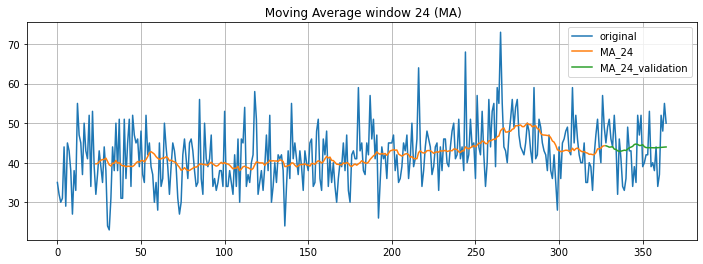

In [529]:
plot_TS(series, title=' Moving Average window 24 (MA)')

plt.plot(X_train.rolling(24).mean(),label='MA_24')

plt.plot(range(TS_length-len(X_test),TS_length,1) , MA_predict(X_train, window=24, n_steps = len(X_test)) ,label='MA_24_validation'  )

plt.legend()

Построим WMA:

In [557]:
weights = [1,2,4]
for i in range(3,14,1):
    weights.append(2**i)
    y_train = get_MA_weights(X_train, weights=weights ) 
    window = len(weights)
    print(weights, mean_squared_error(X_train[window+1:], y_train[window:]))

[1, 2, 4, 8] 66.89454420364638
[1, 2, 4, 8, 16] 65.96575448710905
[1, 2, 4, 8, 16, 32] 65.29322027645719
[1, 2, 4, 8, 16, 32, 64] 64.87841078182154
[1, 2, 4, 8, 16, 32, 64, 128] 64.97299249504954
[1, 2, 4, 8, 16, 32, 64, 128, 256] 64.50443553253788
[1, 2, 4, 8, 16, 32, 64, 128, 256, 512] 64.67359125785234
[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] 64.86653120586466
[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048] 63.87502514355703
[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096] 63.561470410194346
[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192] 63.761648125247284


In [562]:
weights = [1, 2, 4, 8, 16, 32, 64, 128, 256]
y_pred = WMA_predict(X_test, weights=weights, n_steps = len(X_test)) 
print(mean_squared_error(X_test, y_pred))

92.29349649949407


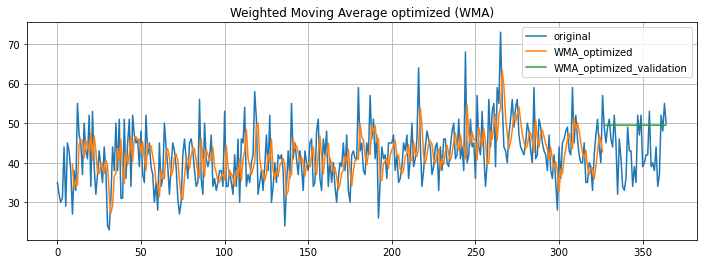

In [561]:
plot_TS(series, title='Weighted Moving Average optimized (WMA)')
weights = [1, 2, 4, 8, 16, 32, 64, 128, 256] #64.50
plt.plot(get_MA_weights(X_train, weights=weights ),label='WMA_optimized')

plt.plot(range(TS_length-len(X_test),TS_length,1) , WMA_predict(X_train,  weights=weights, n_steps = len(X_test)) ,label='WMA_optimized_validation'  )

plt.legend()

Посмтрим предсказание EMA

In [479]:
def MSE_EMA(coefs):
    alpha = coefs
    y_pred = EMA_predict(X_train, n_steps=len(X_test), alpha=alpha )
    return mean_squared_error(X_test, y_pred)
    

In [ ]:
opt = minimize(MSE_EMA, x0=[0], method='Nelder-Mead', bounds=( (0,1) )  ) # 'L-BFGS-B'

In [489]:
alpha_opt = opt.x
print(opt)

 final_simplex: (array([[0.0719375],
       [0.071875 ]]), array([54.29610431, 54.29610525]))
           fun: 54.29610431318968
       message: 'Optimization terminated successfully.'
          nfev: 34
           nit: 17
        status: 0
       success: True
             x: array([0.0719375])


<ipython-input-130-14bd164ec989>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(result)
<ipython-input-130-14bd164ec989>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(result)
<ipython-input-162-d33dd8a48c4c>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(result)[2:]


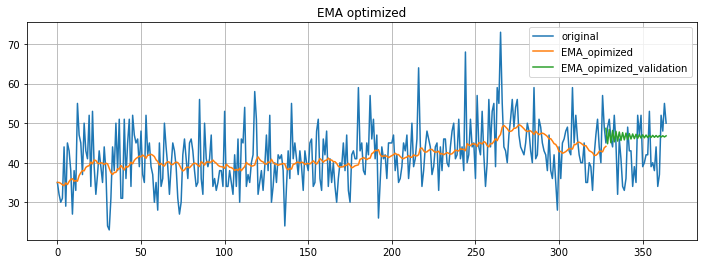

In [490]:
plot_TS(series, title='EMA optimized' )

plt.plot(get_exponential_MA(X_train, alpha= alpha_opt), label = 'EMA_opimized' )

plt.plot(range(len(series) - len(X_test), len(series)) ,EMA_predict(X_train,n_steps=len(X_test), alpha= alpha_opt ), label = 'EMA_opimized_validation' )
plt.legend()

Посмтрим предсказание DEMA

In [483]:
def MSE_DEMA(coefs):
    alpha, betta = coefs
    y_pred = DEMA_predict(X_train, n_steps=len(X_test), alpha=alpha, betta=betta)
    return mean_squared_error(X_test, y_pred)
    

In [ ]:
opt = minimize(MSE_DEMA, x0=[0,0], method='Nelder-Mead', bounds=( (0,1),(0,1) )  ) # 'L-BFGS-B'

In [485]:
alpha_opt, betta_opt = opt.x
print(opt)

 final_simplex: (array([[0.00506308, 0.00238355],
       [0.00508519, 0.00237426],
       [0.00509122, 0.0023662 ]]), array([41.19906194, 41.19906887, 41.19915193]))
           fun: 41.19906194445318
       message: 'Optimization terminated successfully.'
          nfev: 85
           nit: 46
        status: 0
       success: True
             x: array([0.00506308, 0.00238355])


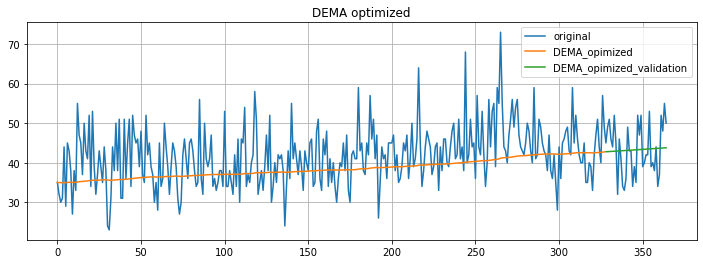

In [486]:
plot_TS(series, title='DEMA optimized' )

plt.plot(get_DEMA(X_train, alpha= alpha_opt, betta=betta_opt  )[0], label = 'DEMA_opimized' )

plt.plot(range(len(series) - len(X_test), len(series)) ,DEMA_predict(X_train,n_steps=len(X_test), alpha= alpha_opt, betta=betta_opt ), label = 'DEMA_opimized_validation' )
plt.legend()

Посмтрим предсказание TEMA

In [492]:
opt = minimize(MSE, x0=[0,0,0], method='L-BFGS-B', bounds=( (0,1),(0,1),(0,1) ) )

In [493]:
alpha_opt, betta_opt, gamma_opt = opt.x
print(opt)

      fun: 147.60802664468096
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.17387607e+02,  4.09272616e-04, -0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 40
      nit: 8
     njev: 10
   status: 0
  success: True
        x: array([1.        , 0.01117454, 1.        ])


проверим на тест(валидационной выборке)

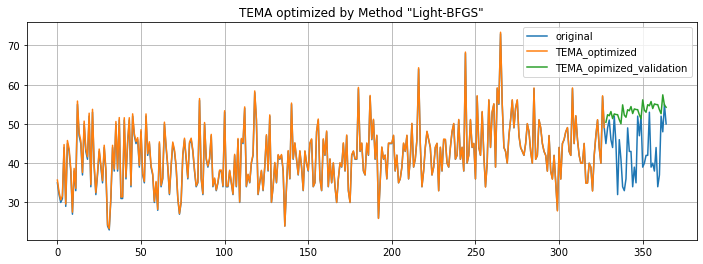

In [494]:
plot_TS(series, title='TEMA optimized by Method "Light-BFGS"')

plt.plot(get_TEMA(X_train, alpha = alpha_opt, betta = betta_opt, gamma=gamma_opt)[0], label='TEMA_optimized')

plt.plot(range(len(series) - len(X_test), len(series)) ,TEMA_predict(X_train,n_steps=len(X_test), alpha= alpha_opt, betta=betta_opt, gamma=gamma_opt ), label = 'TEMA_opimized_validation' )

plt.legend()

#### Стационарный ряд. Результаты на валидационной выборке: 
   - MA window=24     MSE = 40.1 .  В среднюю попала.
   - WMA степень 2(9) MSE = 92.3 .  В среднюю НЕ попала. 
   - EMA оптимизация  MSE = 54.3 .  В среднюю НЕ попала. 
   - DEMA оптимизация MSE = 41.1 .  В среднюю попала.
   - TEMA оптимизация MSE = 147.6 . В среднюю НЕ попала.
    
Лучшим алгоритмом становится **MA(24)**. Что и ожидалось.   
    